# Tutorial 5: Validating the Unwindowed $B_\ell(k_1,k_2,k_3)$ Estimators

In this tutorial we will validate the PolyBin3D unwindowed bispectrum estimators. For this purpose, we'll generate some fake data with and without a mask, and verify that the unwindowed bispectra match those from unmasked data. This closely follows the power spectrum tests in tutorial 2.

### Preliminaries

We start by importing the packages we'll need, as well as defining some useful plotting functions.

In [1]:
%pylab inline
import os, sys
from nbodykit.lab import * # for various utility functions
import PolyBin3D as pb # the main code
from scipy.interpolate import interp1d

def plotter(mat,axis=2,shift=True,vmax=None,title=''):
    """General purpose function for plotting a 3D density field, averaging over a specified axis. 
    
    We optionally apply an FFTshift operation, and truncate the plot to some symmetric range of values: [-vmax, vmax].
    """
    plt.figure()
    if shift:
        plot_mat = np.fft.fftshift(mat)
    else:
        plot_mat = mat
    to_plot = plot_mat.real.mean(axis=axis)
    if vmax is None:
        vmax = np.max(np.abs(to_plot))
    if len(title)>0:
        plt.title(title)
    plt.imshow(to_plot,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    plt.colorbar();
    plt.show();
    
def plot_corr(f, v=1, subtract_identity=True, title=''):
    """Plot a correlation matrix, optionally subtracting the identity."""
    cfish = f/np.sqrt(np.outer(np.diag(f),np.diag(f)))
    plt.figure()
    if len(title)>0:
        plt.title(title)
    plt.imshow(cfish-subtract_identity*np.eye(len(cfish)),cmap=cm.RdBu_r,vmax=v,vmin=-v);
    plt.colorbar();
    
    for i in range(bspec.Nl-1):
        plt.hlines((i+1)*bspec.N3-0.5, 0, 2*bspec.N_bins, linestyles='--',alpha=0.5)
        plt.vlines((i+1)*bspec.N3-0.5, 0, 2*bspec.N_bins, linestyles='--',alpha=0.5)
    plt.xlim(-0.5,bspec.N_bins-0.5)
    plt.ylim(bspec.N_bins-0.5,-0.5)
    plt.xlabel('Bin Index 1',fontsize=12)
    plt.ylabel('Bin Index 2',fontsize=12)

Populating the interactive namespace from numpy and matplotlib


### 1. Set-up

First, we'll generate some mock data. The idea will be to generate data that we exactly know the bispectrum of, so we can test if we exactly recover it. For this reason, we'll use a global line-of-sight (including anisotropy) and generate redshift-space multipoles with $\ell\in\{0,2\}$. We'll additionally cut out any modes outside the $k$-range we're interested in to avoid any residual leakage (induced by the mask).

First, we load a mask and associated attributes. This is adapted from the BOSS DR12 LOWZ-SGC survey data and contains significant anisotropy and power across a broad range of scales.

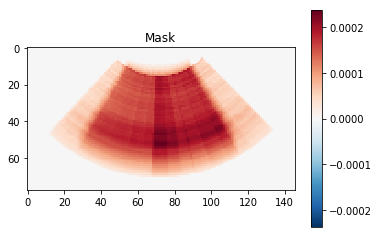

In [2]:
with np.load('sample_mask.npz') as d:
    mask_grid = d['mask']
    gridsize = d['gridsize']
    boxsize = d['boxsize']
nbar = np.average(mask_grid, weights=mask_grid!=0)
    
plotter(mask_grid, title='Mask')

Next, we create a fiducial set of power spectrum multipoles (assuming the Kaiser formula).

In [3]:
# Define fiducial power spectrum (assuming the Kaiser formula)
cosmo = cosmology.Cosmology(h=0.676).match(Omega0_m=0.31)
redshift = 0.55
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
b1 = 1.8
fz = cosmo.scale_independent_growth_rate(redshift)

# Define fiducial power spectrum (assuming the Kaiser formula)
k_arr = np.arange(0.0001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr+1./nbar
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr

# Define weighting, only using the monopole
Pk_fiducial = [k_arr, P0_arr]

We'll also create a function to create a dataset, either with or without the mask. We'll add a TSC pixel-window function to the data (added after the mask, emulating real data).

For this, we need to generate data with a known bispectrum. This can be achieved by creating a Gaussian random field $\delta(\vec k)$ and applying the following transformation:
$$\delta(\vec k)\to \delta(\vec k)+\epsilon\,\Delta(\vec k)$$ with
$$\Delta(\vec k) = \frac{1}{6}\beta(k)\int d\vec x\,e^{-i\vec k\cdot\vec x}\int_{\vec p}\frac{\beta(p)}{P_{\rm tot}(\vec p)}\delta(\vec p)\int_{\vec p'}\frac{\beta(p')}{P_{\rm tot}(\vec p')}\delta(\vec p').$$
At leading order in $\epsilon$, this yields the factorizable bispectrum
$$B(\vec k_1,\vec k_2,\vec k_3) = \epsilon\beta(k_1)\beta(k_2)\beta(k_3),$$
which contains only the $\ell=0$ mode. To get the scaling correct, we'll assume $\beta(k) = P^{2/3}(k)$ (if $k$ is in the $k$-range of interest) and use only a monopole power spectrum. We use a small value of $\epsilon$ to ensure that the higher-order corrections to the bispectrum (from the $\epsilon^3\langle{\Delta(\vec k_1)\Delta(\vec k_2)\Delta(\vec k_3)\rangle}$ piece) are small.


# Dimensions: [1.01e+03, 1.91e+03, 1.06e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [78, 146, 82]
# Fundamental frequency: [0.006, 0.003, 0.006] h/Mpc
# Nyquist frequency: [0.243, 0.240, 0.243] h/Mpc
# Pixel window: interlaced-tsc


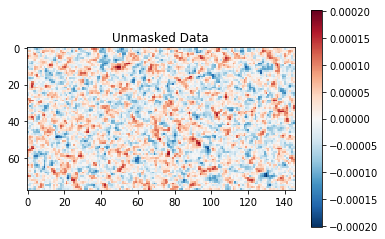

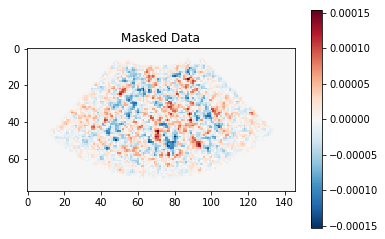

In [4]:
## Load base class
base = pb.PolyBin3D(boxsize, gridsize, Pk_fiducial, 
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs ('fftw' for cpu, 'jax' for gpu)
                 nthreads=4, # number of CPUs for performing FFTs (only applies to 'fftw' backend)
                 sightline='global', # line-of-sight [global = z-axis, local = relative to pair]
                )

# Define k-min and k-max
k_min = 0.02
k_max = 0.10

bin_grid = (base.modk_grid>=k_min)*(base.modk_grid<k_max)
# Define beta as P^{2/3}, dropping shot-noise term
epsilon = 0.5
beta_grid = interp1d(k_arr,P0_arr-1./nbar, fill_value=0., bounds_error=False)(base.modk_grid)**(2./3.)*bin_grid

def create_data(seed, apply_mask=False):
    """Create a dataset including a factorizable bispectrum, optionally with a mask"""
    
    # Generate GRF data
    density_grf = base.generate_data(seed, Pk_input=[k_arr,P0_arr])
    
    # Remove pixelation window
    if base.pixel_window=='none':
        depixeled_density = density_grf.copy()
    else:
        depixeled_density = base.to_real(base.to_fourier(density_grf)/base.pixel_window_grid)
    
    # Add bispectrum
    filt_field = base.to_real(beta_grid*base.invPk0_grid*base.to_fourier(depixeled_density))
    Delta_k = 1./6.*beta_grid*base.to_fourier(filt_field**2.)
    depixeled_density += epsilon*base.to_real(Delta_k).real
    
    # Optionally apply the mask
    if apply_mask:
        masked_density = mask_grid*depixeled_density
    else:
        masked_density = nbar*depixeled_density
        
    # Replace pixel window and return
    if base.pixel_window=='none':
        return masked_density
    else:
        return base.to_real(base.pixel_window_grid*base.to_fourier(masked_density))

# Plot a dataset
plotter(create_data(42, apply_mask=False), title='Unmasked Data')
plotter(create_data(42, apply_mask=True), title='Masked Data')

### 2. Compute Bispectra of *Unmasked* Data 

We now compute the bispectrum of the unmasked data using PolyBin3D. To do this,  we'll load the bispectrum class and compute spectra using ``Bk_ideal``. We'll iterate over a bunch of simulations to minimize the errorbars, and use a small number of $k$-bins for speed.

In [5]:
# Define some k-bins and ell_max
k_edges = np.linspace(k_min, k_max, 6, endpoint=True)
lmax = 2

# Load the bispectrum class with uniform mask
bspec = pb.BSpec(base, k_edges, lmax=lmax, mask = nbar, 
                 applySinv = None, k_bins_squeeze=None, include_partial_triangles=False)

# Define the k-bin centers
k123s = bspec.get_ks()


Binning: 5 bins in [0.020, 0.100] h/Mpc
l-max: 2
N_bins: 56
Mask: constant


In [6]:
Bks_unmasked = []
N_sim = 250
for sim in range(N_sim):
    if (sim+1)%5==0: print("Iteration %d of %d"%(sim+1,N_sim))

    # Generate GRF
    density_grf = create_data(sim, apply_mask=False)

    # Compute bispectrum
    Bks_unmasked.append(bspec.Bk_ideal(density_grf, discreteness_correction=False))
    
# Cleanup
def _compute_mean_std(Bs):
    Bk_mean = {key: np.mean([B[key] for B in Bs],axis=0) for key in ['b0','b2']}
    Bk_std = {key: np.std([B[key] for B in Bs],axis=0) for key in ['b0','b2']}
    return {'mean':Bk_mean, 'std':Bk_std}

Bk_unmasked = _compute_mean_std(Bks_unmasked)

Computing degeneracy factor
Computing ideal Fisher matrix
Iteration 5 of 250
Iteration 10 of 250
Iteration 15 of 250
Iteration 20 of 250
Iteration 25 of 250
Iteration 30 of 250
Iteration 35 of 250
Iteration 40 of 250
Iteration 45 of 250
Iteration 50 of 250
Iteration 55 of 250
Iteration 60 of 250
Iteration 65 of 250
Iteration 70 of 250
Iteration 75 of 250
Iteration 80 of 250
Iteration 85 of 250
Iteration 90 of 250
Iteration 95 of 250
Iteration 100 of 250
Iteration 105 of 250
Iteration 110 of 250
Iteration 115 of 250
Iteration 120 of 250
Iteration 125 of 250
Iteration 130 of 250
Iteration 135 of 250
Iteration 140 of 250
Iteration 145 of 250
Iteration 150 of 250
Iteration 155 of 250
Iteration 160 of 250
Iteration 165 of 250
Iteration 170 of 250
Iteration 175 of 250
Iteration 180 of 250
Iteration 185 of 250
Iteration 190 of 250
Iteration 195 of 250
Iteration 200 of 250
Iteration 205 of 250
Iteration 210 of 250
Iteration 215 of 250
Iteration 220 of 250
Iteration 225 of 250
Iteration 230 of 

Let's plot the results. The output bispectrum monopole looks consistent with the input theory, as expected (though differences can arise depending on how we define the bin centers). Furthermore, the quadrupole is consistent with zero. (Note that the errorbars are the error in a *single* realization, so remain large even though we used many simulations).

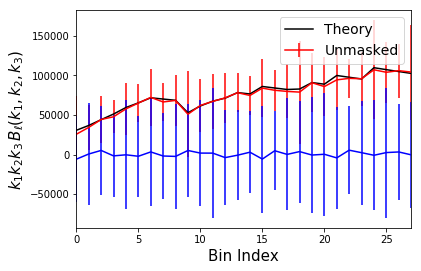

In [7]:
# Compute theory bispectra
beta_int = interp1d(k_arr,(P0_arr-1./nbar)**(2./3.))
B0_th = epsilon*beta_int(k123s[0])*beta_int(k123s[1])*beta_int(k123s[2])

cs = ['r','b']
weights = k123s.prod(axis=0)

plt.plot(np.arange(len(weights)),weights*B0_th, label='Theory', c='k')
for l in [0,2]:
    plt.errorbar(np.arange(len(weights)), weights*Bk_unmasked['mean']['b%d'%l], yerr=weights*Bk_unmasked['std']['b%d'%l],c=cs[l//2], label='Unmasked')
    if l==0: plt.legend(fontsize=14);
plt.xlim(0,bspec.N3-1)
#plt.ylim(-50000,50000);
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15);

### 3. Compute Bispectra of *Masked* Data 

We now compute the bispectrum of the masked data now using the ``Bk_unwindowed`` routine. Before doing so, we'll decide on a weighting scheme, and compute the Fisher matrix. Here, we'll use a simple FKP-like weighting $$\mathsf{S}^{-1}(\vec x, \vec y) = \frac{\delta_{\rm D}(\vec x-\vec y)}{n(\vec x)P_{\rm FKP}+1}.$$

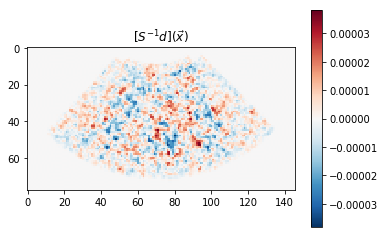

In [8]:
# Define a real-space FKP weight
P_fkp = 1e4
fkp_weight = 1./(mask_grid*P_fkp+1)

def applySinv_fkp(input_data, input_type='real', output_type='real'):
    """Apply an FKP-like filter to the data."""
   
    # Read in the data, and convert it to real-space if necessary
    if input_type=='fourier':
        input_real = base.to_real(input_data)
    else:
        input_real = input_data.copy()
    
    # Apply FKP weight
    output_real = input_real*fkp_weight
    
    # Return output in real- or Fourier-space
    if output_type=='real':
        return output_real
    else:
        return base.to_fourier(output_real)

# Test the function
plotter(applySinv_fkp(create_data(42, apply_mask=True)), title=r'$[S^{-1} d](\vec x)$');

Below we compute the Fisher matrix using Monte Carlo realizations. Using more realizations will reduce the Monte Carlo noise (with the variance scaling as $1/N_{\rm it}$) which can lead to bias in the unwindowed estimators.

In [9]:
# Load the bispectrum class with our S^-1 function and the non-uniform mask
bspec = pb.BSpec(base, k_edges, lmax = lmax, applySinv = applySinv_fkp, mask = mask_grid, 
                 k_bins_squeeze = None, include_partial_triangles=False)

# Number of Monte Carlo iterations
N_it = 50

# Iterate over realizations
fishs = []
for s in range(N_it):
    print("## Computing iteration %d of %d"%(s+1,N_it))
    fishs.append(bspec.compute_fisher_contribution(s,verb=(s==0)))

# Clean-up output
fish = np.mean(fishs,axis=0)

# # Alternative:
# fish = bspec.compute_fisher(N_it, 1, False)


Binning: 5 bins in [0.020, 0.100] h/Mpc
l-max: 2
N_bins: 56
Mask: spatially varying
## Computing iteration 1 of 50
Computing degeneracy factor
Generating GRFs
Allocating 1.56 GB of memory

# Computing Q[S^-1.W.a] maps for random field 1
Computing g_{b,0}(r) maps
Computing matrix for k-bin 0 of 5
Computing matrix for k-bin 1 of 5
Computing matrix for k-bin 2 of 5
Computing matrix for k-bin 3 of 5
Computing matrix for k-bin 4 of 5

# Computing S^-1.W.Q[A^-1.a] maps for random field 1
Computing g_{b,0}(r) maps
Computing matrix for k-bin 0 of 5
Computing matrix for k-bin 1 of 5
Computing matrix for k-bin 2 of 5
Computing matrix for k-bin 3 of 5
Computing matrix for k-bin 4 of 5

# Computing Q[S^-1.W.a] maps for random field 2
Computing g_{b,0}(r) maps
Computing matrix for k-bin 0 of 5
Computing matrix for k-bin 1 of 5
Computing matrix for k-bin 2 of 5
Computing matrix for k-bin 3 of 5
Computing matrix for k-bin 4 of 5

# Computing S^-1.W.Q[A^-1.a] maps for random field 2
Computing g_{b,0}

Now we compute the bispectrum, folding in the Fisher matrix we just computed. To assess the impact of the window function on our data, we'll also compute the *window-convolved* spectra using the ``Bk_ideal`` routine. We'll drop the linear term in the bispectrum numerator for speed here (since it doesn't change the estimator mean).

In [11]:
Bks_masked_ideal = []
Bks_masked_unwindowed = []
for sim in range(N_sim):
    if (sim+1)%5==0: print("Iteration %d of %d"%(sim+1,N_sim))

    # Generate random map
    density_sim = create_data(sim, apply_mask=True)

    # Compute ideal bispectrum
    Bks_masked_ideal.append(bspec.Bk_ideal(density_sim, discreteness_correction=False))
    
    # Compute unwindowed bispectrum
    Bks_masked_unwindowed.append(bspec.Bk_unwindowed(density_sim, fish=fish, include_linear_term=False))

# Cleanup
Bk_masked_ideal = _compute_mean_std(Bks_masked_ideal)
Bk_masked_unwindowed = _compute_mean_std(Bks_masked_unwindowed)

Iteration 5 of 250
Iteration 10 of 250
Iteration 15 of 250
Iteration 20 of 250
Iteration 25 of 250
Iteration 30 of 250
Iteration 35 of 250
Iteration 40 of 250
Iteration 45 of 250
Iteration 50 of 250
Iteration 55 of 250
Iteration 60 of 250
Iteration 65 of 250
Iteration 70 of 250
Iteration 75 of 250
Iteration 80 of 250
Iteration 85 of 250
Iteration 90 of 250
Iteration 95 of 250
Iteration 100 of 250
Iteration 105 of 250
Iteration 110 of 250
Iteration 115 of 250
Iteration 120 of 250
Iteration 125 of 250
Iteration 130 of 250
Iteration 135 of 250
Iteration 140 of 250
Iteration 145 of 250
Iteration 150 of 250
Iteration 155 of 250
Iteration 160 of 250
Iteration 165 of 250
Iteration 170 of 250
Iteration 175 of 250
Iteration 180 of 250
Iteration 185 of 250
Iteration 190 of 250
Iteration 195 of 250
Iteration 200 of 250
Iteration 205 of 250
Iteration 210 of 250
Iteration 215 of 250
Iteration 220 of 250
Iteration 225 of 250
Iteration 230 of 250
Iteration 235 of 250
Iteration 240 of 250
Iteration 24

Let's plot the results! 

Below, we compare the bispectra computed using the unmasked data (black) to those from the masked data with the ideal (dark colors and points) and de-windowed (light colors and crosses) estimators. For visibility, we plot the error in the mean here. Notably, there are significant distortions induced by the mask, such that the ideal spectra do *not* match the masked spectra (particularly on large scales). However, the de-windowed estimators perform much better and seem to be consistent with the truth. Here, there's some residual distortions from the finite number of Monte Carlo simulations used to estimate the Fisher matrix, but this can be reduced with more simulations. We note that this problem is particularly difficult due to the highly non-trivial window function geometry.

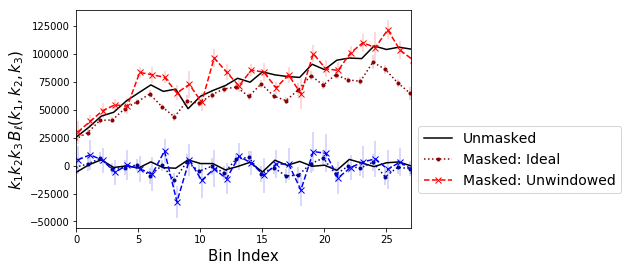

In [24]:
cs = ['r','b']
cs2 = ['darkred','darkblue']
for l in [0,2]:
    plt.errorbar(np.arange(len(weights)), weights*Bk_unmasked['mean']['b%d'%l],
                 alpha=1.,c='k', label='Unmasked')
    plt.errorbar(np.arange(len(weights))-0.1, weights*Bk_masked_ideal['mean']['b%d'%l],
                 c=cs2[l//2], ls=':',label='Masked: Ideal',marker='.')
    plt.errorbar(np.arange(len(weights))-0.1, weights*Bk_masked_ideal['mean']['b%d'%l], 
                 yerr=weights*Bk_masked_ideal['std']['b%d'%l]/np.sqrt(N_sim),
                 c=cs2[l//2], ls='', marker='',alpha=0.2)
    plt.errorbar(np.arange(len(weights))+0.1, weights*Bk_masked_unwindowed['mean']['b%d'%l], 
                 c=cs[l//2], ls='--',label='Masked: Unwindowed',marker='x')
    plt.errorbar(np.arange(len(weights))+0.1, weights*Bk_masked_unwindowed['mean']['b%d'%l], 
                 yerr=weights*Bk_masked_unwindowed['std']['b%d'%l]/np.sqrt(N_sim),
                 c=cs[l//2], ls='', marker='',alpha=0.2)
    if l==0: plt.legend(fontsize=14,bbox_to_anchor=(1.,0.5));
plt.xlim(0,bspec.N3-1)
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15);

Let's also compare the variances. The masked spectra have significantly higher variances; this is expected since the mask removes much of the data. We also find that the ideal spectra appear to have lower variance than the unwindowed spectra? This occurs due to the differences in correlation structure; unwindowed spectra have significant anti-correlations between neighboring bins.

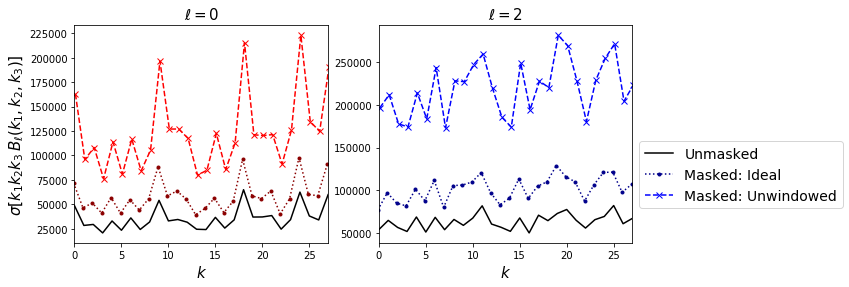

In [27]:
cs = ['r','b']
cs2 = ['darkred','darkblue']
fig,ax = plt.subplots(1,2,figsize=(10,4),sharex=True)
for l in [0,2]:
    ax[l//2].plot(np.arange(len(weights)), weights*Bk_unmasked['std']['b%d'%l],
             alpha=1.,c='k', label='Unmasked')
    ax[l//2].plot(np.arange(len(weights))-0.1, weights*Bk_masked_ideal['std']['b%d'%l],
                 c=cs2[l//2], ls=':',label='Masked: Ideal',marker='.')
    ax[l//2].plot(np.arange(len(weights))+0.1, weights*Bk_masked_unwindowed['std']['b%d'%l], 
                 c=cs[l//2], ls='--',label='Masked: Unwindowed',marker='x')
    ax[l//2].set_xlim(0, bspec.N3-1)
    ax[l//2].set_xlabel(r'$k$',fontsize=15)
    ax[l//2].set_title(r'$\ell=%d$'%l,fontsize=15)
ax[0].set_ylabel(r'$\sigma[k_1k_2k_3\,B_\ell(k_1,k_2,k_3)]$',fontsize=15);
ax[1].legend(fontsize=14,bbox_to_anchor=(1.,0.5));    

Let's also compare the covariances. We find that the unmasked spectra are approximately uncorrelated except for correlations between $\ell=0$ and $\ell=2$ (induced by redshift-space distortions). When the mask is included, there's large off-diagonal correlations between neighboring bins in the ideal (FKP) estimators. For the unwindowed estimators, we find slight *anti-correlations*; this occurs since $\mathcal{F}^{-1/2}\hat{p}$ is approximately diagonal (for an ideal $\mathsf{S}^{-1}$ weighting). Up to noise, this seems to agree with the expected inverse-Fisher matrix structure (although some deviations will occur since our data is *not* Gaussian distributed).

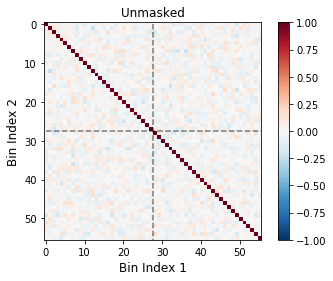

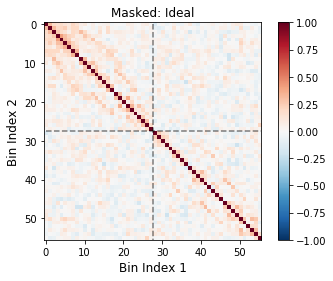

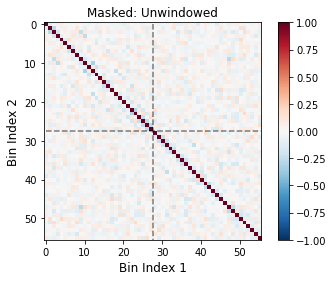

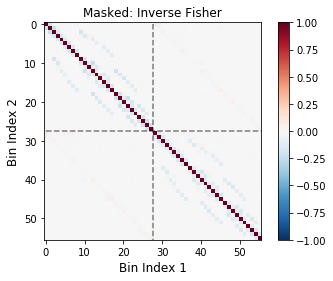

In [22]:
def compute_cov(Bs):
    """Compute the covariance matrix from a set of bispectra."""
    B_stack = np.asarray([np.concatenate([B['b0'],B['b2']]) for B in Bs])
    return np.cov(B_stack.T)

cov_unmasked = compute_cov(Bks_unmasked)
cov_masked_ideal = compute_cov(Bks_masked_ideal)
cov_masked_unwindowed = compute_cov(Bks_masked_unwindowed)

plot_corr(cov_unmasked, subtract_identity=0, title='Unmasked')
plot_corr(cov_masked_ideal, subtract_identity=0, title='Masked: Ideal')
plot_corr(cov_masked_unwindowed, subtract_identity=0, title='Masked: Unwindowed')
plot_corr(bspec.inv_fish, subtract_identity=0, title='Masked: Inverse Fisher')

Finally, we'll test the optimality of the unwindowed estimators by computing the total signal-to-noise ratio of the bispectrum measurements. We find that the masked spectra have much lower signal-to-noise, which matches expectations since the mask leads to information loss. The unwindowed estimators have slightly higher signal-to-noise than the ideal estimators, as expected. This is despite the larger variances seen above, and occurs due to the anticorrelations between neighboring bins.

In [16]:
def compute_snr(Bs):
    """Compute the covariance matrix from a set of bispectra."""
    B_stack = np.asarray([np.concatenate([B['b0'],B['b2']]) for B in Bs])
    cov = np.cov(B_stack.T)
    icov = np.linalg.inv(cov)
    B_mean = np.mean(B_stack,axis=0)
    snr_sq = np.matmul(B_mean,np.matmul(icov, B_mean))
    return np.sqrt(snr_sq)

snr_unmasked = compute_snr(Bks_unmasked)
snr_masked_ideal = compute_snr(Bks_masked_ideal)
snr_masked_unwindowed = compute_snr(Bks_masked_unwindowed)
print("Unmasked SNR: %.1f"%snr_unmasked)
print("Masked SNR: %.1f (ideal) vs %.1f (unwindowed)"%(snr_masked_ideal,snr_masked_unwindowed))

Unmasked SNR: 13.4
Masked SNR: 4.1 (ideal) vs 5.1 (unwindowed)


This completes the tutorial!